<a href="https://colab.research.google.com/github/kazu1999/image2sentence2image/blob/main/image2sentence2image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#DALLE のインストール

# Pytorchバージョン変更
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html 

# Pytorch画像処理ライブラリー・インストール
! pip install kornia==0.5.0

# CLIP関連コードのコピー
! git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

# CLIPのモデル化
! pip install ftfy regex

import clip
model, preprocess = clip.load('ViT-B/32', jit=True)  
model = model.eval()  

# DALL-Eのモデル化
! pip install DALL-E
from dall_e import map_pixels, unmap_pixels, load_model
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:24tcmalloc: large alloc 1147494400 bytes == 0x3a5b8000 @  0x7fbb6cd6b615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:24tcmalloc: large alloc 1434370048 bytes == 0x7ec0e000 @  0x7fbb6cd6b615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 113MiB/s]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 28.2 MB/s 
     |████████████████████████████████| 70 kB 8.5 MB/s 
     |████████████████████████████████| 139 kB 65.1 MB/s 
     |████████████████████████████████| 2.3 MB 67.3 MB/s 
     |████████████████████████████████| 843 kB 61.8 MB/s 
     |████████████████████████████████| 127 kB 65.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#DALLE のインポートと関数定義
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import kornia
import PIL
import os, io, sys
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from google.colab import output
import requests

# 初期設定
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape
target_image_size = sideX
tau_value = 2.

# 画像表示・保存
def displ(img):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  imageio.imwrite('output.png', np.array(img))
  return display.Image('output.png')

# 画像のランダム切り出し
def augment(out, cutn=16):
  p_s = []
  for ch in range(cutn):
    sizey = int(torch.zeros(1,).uniform_(.5, .99)*sideY)
    sizex = int(torch.zeros(1,).uniform_(.5, .99)*sideX)
    offsetx = torch.randint(0, sideX - sizex, ())
    offsety = torch.randint(0, sideY - sizey, ())
    apper = out[:, :, offsetx:offsetx + sizex, offsety:offsety + sizey]
    apper = apper + .1*torch.rand(1,1,1,1).cuda()*torch.randn_like(apper, requires_grad=True)
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = augs(torch.cat(p_s, 0))
  return into

# 正規化と回転設定
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
augs = kornia.augmentation.RandomRotation(30).cuda()

# パラメータの設定
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        hots = torch.nn.functional.one_hot((torch.arange(0, 8192).to(torch.int64)), num_classes=8192)
        rng = torch.zeros(1, 64*64, 8192).uniform_()
        for i in range(64*64):
            rng[0,i] = hots[[np.random.randint(8191)]]
        rng = rng.permute(0, 2, 1)
        self.normu = torch.nn.Parameter(rng.cuda().view(1, 8192, 64*64))
        
    def forward(self):      
      normu = torch.nn.functional.gumbel_softmax(self.normu.reshape(1,64*64,8192), dim=1, tau=tau_value).view(1, 8192, 64, 64)
      return normu 



In [ ]:
%cd ..

/content


In [ ]:
!ls

CLIP  sample_data


In [ ]:
# install transformer & CLIP
! pip install transformers
! pip install git+https://github.com/openai/CLIP.git

# get code from github
! git clone https://github.com/cedro3/CLIP_prefix_caption.git
%cd CLIP_prefix_caption

# install library
! pip install cog
! pip install redis

# define function
from predict import *
from function import *


# CLIP model + GPT2 tokenizer
clip_model, preprocess = clip.load("ViT-B/32", device='cuda', jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# download pretrained_model
! mkdir pretrained_model
! pip install --upgrade gdown
import gdown
gdown.download('https://drive.google.com/uc?id=1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX', 'pretrained_model/coco_weights.pt', quiet=False)




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 19.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.2 MB/s 
     |████████████████████████████████| 596 kB 56.2 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yfrvlc9l
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-yfrvlc9l
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=5313e1161fdf9e9d308096fb89d42405c7d00926513c62d5075a5e127fd37b35
  Stored in directory: /tmp/pip-ephem-wheel-cache-0pltpjy8/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da

Cloning into 'CLIP_prefix_caption'...
remote: Enumerating objects: 186, done.
remote: Total 186 (delta 0), reused 0 (delta 0), pack-reused 186
Receiving objects: 100% (186/186), 2.18 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/CLIP_prefix_caption
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cog: filename=cog-0.0.3-py3-none-any.whl size=8127 sha256=98d2d09a7e9480ee8aaefcf690fd88f3b8a9cf2d4bc8fedbe17fc9fe44d8f50a
  Stored in directory: /root/.cache/pip/wheels/0e/aa/8e/91c99321b6f25ca075d40fcd5b61857de2e0f94f58331f482c
Successfully built cog
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 246 kB 36.4 MB/s 


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14951 sha256=15f41f199c54366cce32fbba289248185fa785438fd24280dbab63af79169417
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Downloading...
From: https://drive.google.com/uc?id=1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX
To: /content/CLIP_prefix_caption/pretrained_model/coco_weights.pt
100%|██████████| 636M/636M [00:16<00:00, 38.7MB/s]


'pretrained_model/coco_weights.pt'

In [ ]:
!ls

clip_prefix_captioning.ipynb  images_coco	   predict.py
cog.yaml		      images_conceptual    pretrained_model
data			      LICENSE		   __pycache__
environment.yml		      notebooks		   README.md
function.py		      output.png	   train.py
images			      parse_coco.py
Images			      parse_conceptual.py


In [ ]:
%cd ..

/content


In [ ]:
%cd CLIP

/content/CLIP


a man is eating a big apple


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


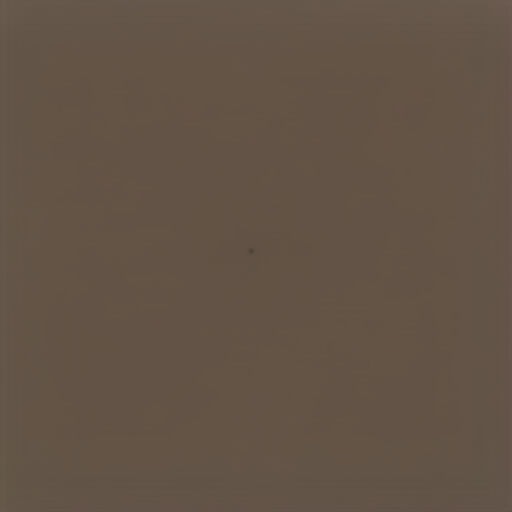

'./images/000000.png'

iter =  0
lr =  0.01005
tau_value =  2.0
loss =  -0.166748046875




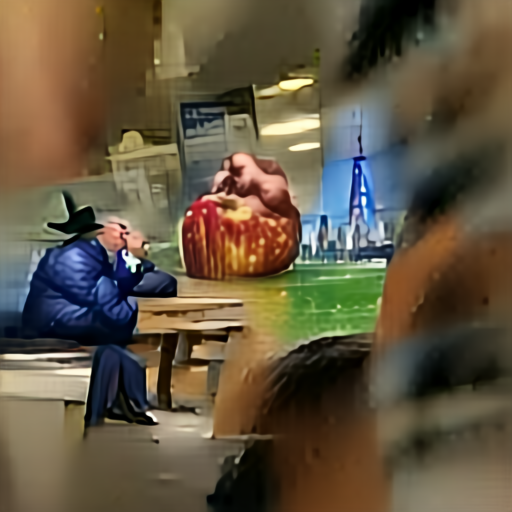

'./images/000020.png'

iter =  1000
lr =  0.12
tau_value =  2.0
loss =  -0.448486328125




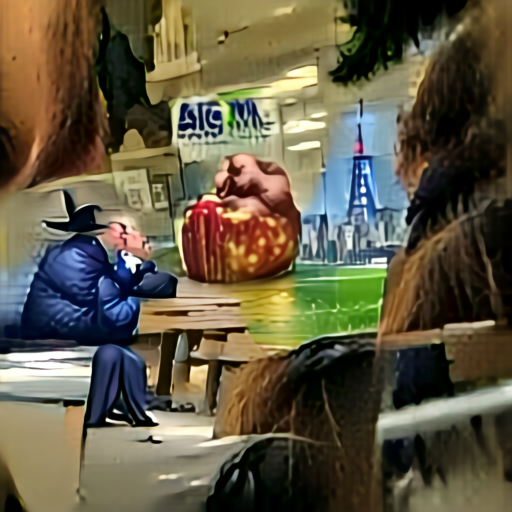

'./images/000040.png'

iter =  2000
lr =  0.12
tau_value =  2.0
loss =  -0.499267578125




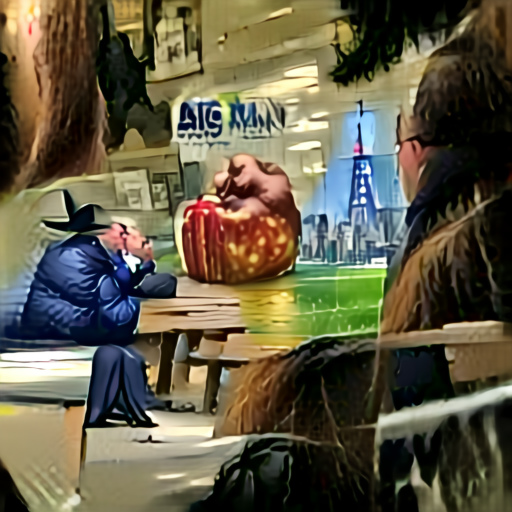

'./images/000060.png'

iter =  3000
lr =  0.12
tau_value =  2.0
loss =  -0.498291015625




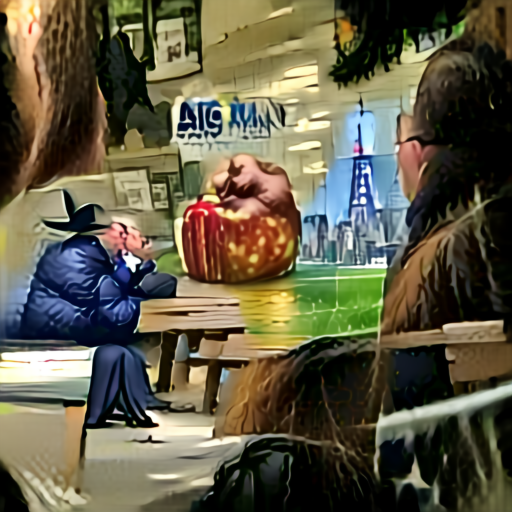

'./images/000080.png'

iter =  4000
lr =  0.12
tau_value =  2.0
loss =  -0.494140625




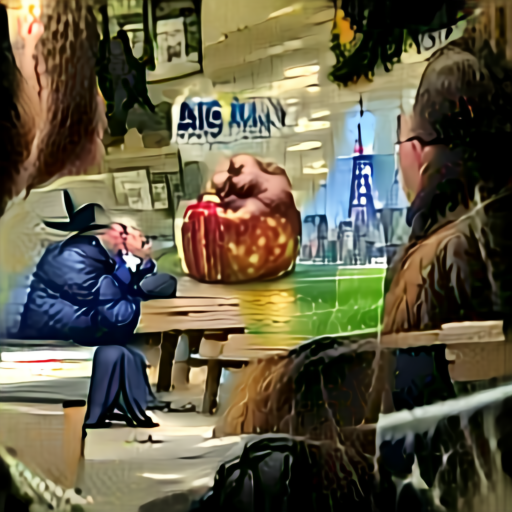

'./images/000100.png'

iter =  5000
lr =  0.12
tau_value =  2.0
loss =  -0.492431640625


/content
/content/CLIP_prefix_caption


<All keys matched successfully>



A man in a baseball cap holding a apple.
/content
/content/CLIP
A man in a baseball cap holding a apple.


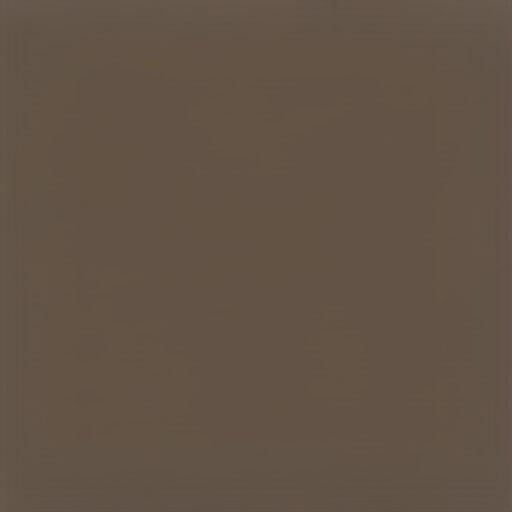

'./images/000000.png'

iter =  0
lr =  0.01005
tau_value =  2.0
loss =  -0.20361328125




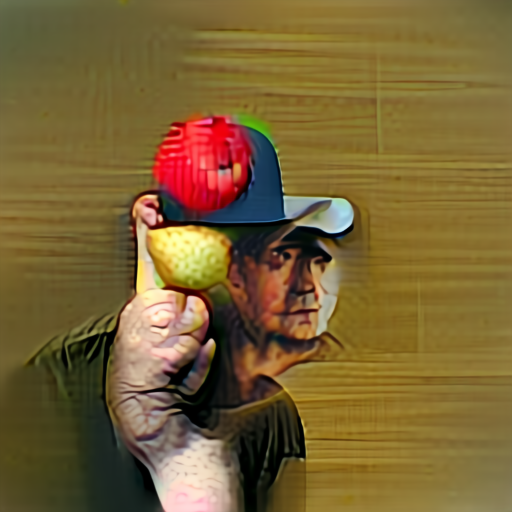

'./images/000020.png'

iter =  1000
lr =  0.12
tau_value =  2.0
loss =  -0.513671875




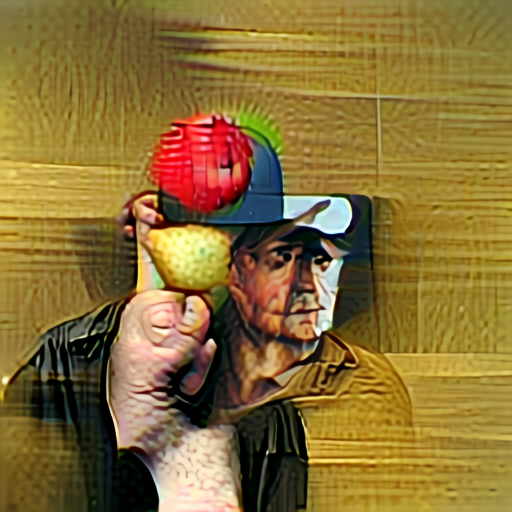

'./images/000040.png'

iter =  2000
lr =  0.12
tau_value =  2.0
loss =  -0.537109375




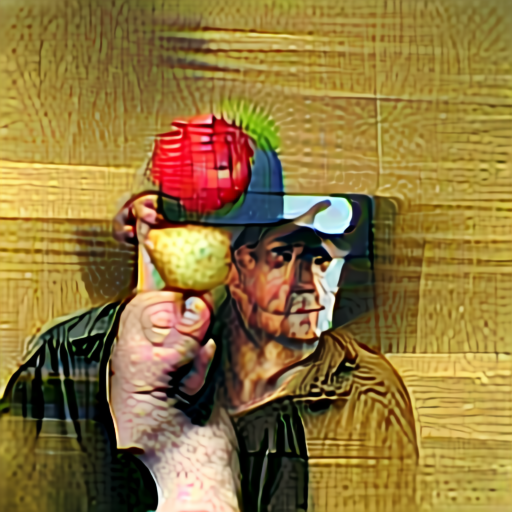

'./images/000060.png'

iter =  3000
lr =  0.12
tau_value =  2.0
loss =  -0.537109375




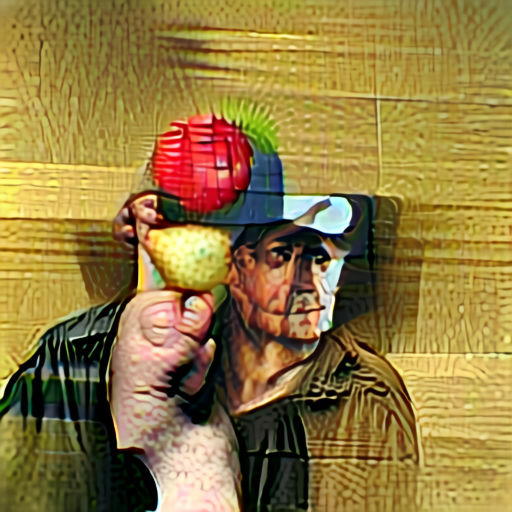

'./images/000080.png'

iter =  4000
lr =  0.12
tau_value =  2.0
loss =  -0.54541015625




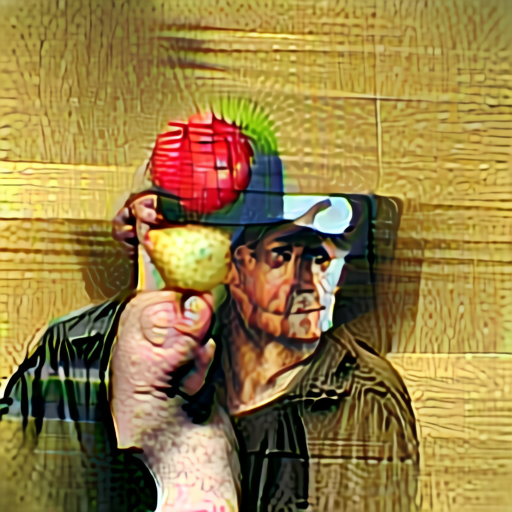

'./images/000100.png'

iter =  5000
lr =  0.12
tau_value =  2.0
loss =  -0.5380859375


/content
/content/CLIP_prefix_caption


<All keys matched successfully>



A man holding a banana and a hat.
/content
/content/CLIP


In [ ]:
#これが本番

num=2
# テキスト入力
text_input = 'a man is eating a big apple' #@param {type:"string"}


for i in range(num):
  print(text_input)
  # テキストを特徴ベクトルに変換
  token = clip.tokenize(text_input)  
  text_v = model.encode_text(token.cuda()).detach().clone() 

  # パラメータリセット
  latent = Pars().cuda()  
  param = [latent.normu]  
  optimizer = torch.optim.Adam([{'params': param, 'lr': .01}]) 

  # images フォルダーリセット
  import shutil
  if os.path.isdir('images'):
    shutil.rmtree('images')
  os.makedirs('images', exist_ok=True)

  # 学習ループ
  for iteration in range(5001):

    # --- 順伝播 ---
    # パラメータから画像を生成
    out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3].float()))
    # 画像をランダム切り出し・回転  
    into = augment(out)
    # 画像を正規化
    into = nom((into))
    # 画像から特徴ベクトルを取得
    image_v = model.encode_image(into)
    # テキストと画像の特徴ベクトルのCOS類似度を計算 
    loss = -torch.cosine_similarity(text_v, image_v).mean()  

    # 逆伝播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    # 学習率の調整
    for g in optimizer.param_groups:
      g['lr'] = g['lr']*1.005
      g['lr'] = min(g['lr'], .12)

    # ログ表示      
    if iteration % 1000 == 0:
      with torch.no_grad():

        # 生成画像の表示・保存
        out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3]).float())  
        displ(out.cpu()[0])  
        shutil.copy('output.png', './images/%s.png'%str(int(iteration/50)).zfill(6))

        # データ表示
        print('iter = ',iteration)
        for g in optimizer.param_groups:
          print('lr = ', g['lr'])
        print('tau_value = ', tau_value)
        print('loss = ',loss.item())
        print('\n')

  %cd ..

  %cd CLIP_prefix_caption

  model_path = 'pretrained_model/coco_weights.pt'

  prefix_length = 10
  clip_caption_model = ClipCaptionModel(prefix_length)
  clip_caption_model.load_state_dict(torch.load(model_path, map_location=CPU)) 
  clip_caption_model = clip_caption_model.eval() 
  clip_caption_model = clip_caption_model.to('cuda')

  image_path = "../CLIP/output.png"
  image = io.imread(image_path)
  use_beam_search = False 
  pil_image = PIL.Image.fromarray(image)
  #pil_img = Image(filename=UPLOADED_FILE)
  #display(pil_image)
  image = preprocess(pil_image).unsqueeze(0).to('cuda')
  with torch.no_grad():
      # if type(model) is ClipCaptionE2E:
      #     prefix_embed = model.forward_image(image)
      # else:
      prefix = clip_model.encode_image(image).to('cuda', dtype=torch.float32)
      prefix_embed = clip_caption_model.clip_project(prefix).reshape(1, prefix_length, -1)
  if use_beam_search:
      generated_text_prefix = generate_beam(clip_caption_model, tokenizer, embed=prefix_embed)[0]
  else:
      generated_text_prefix = generate2(clip_caption_model, tokenizer, embed=prefix_embed)

  print('\n')
  print(generated_text_prefix)
  text_input = generated_text_prefix

  %cd ..
  %cd CLIP


